In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Base_Files.ClassLevyJumpProcesses import TemperedStableSubordinator
import GPy
from Base_Files.Creating_the_NGP import GaussianProcess

np.set_printoptions(suppress=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


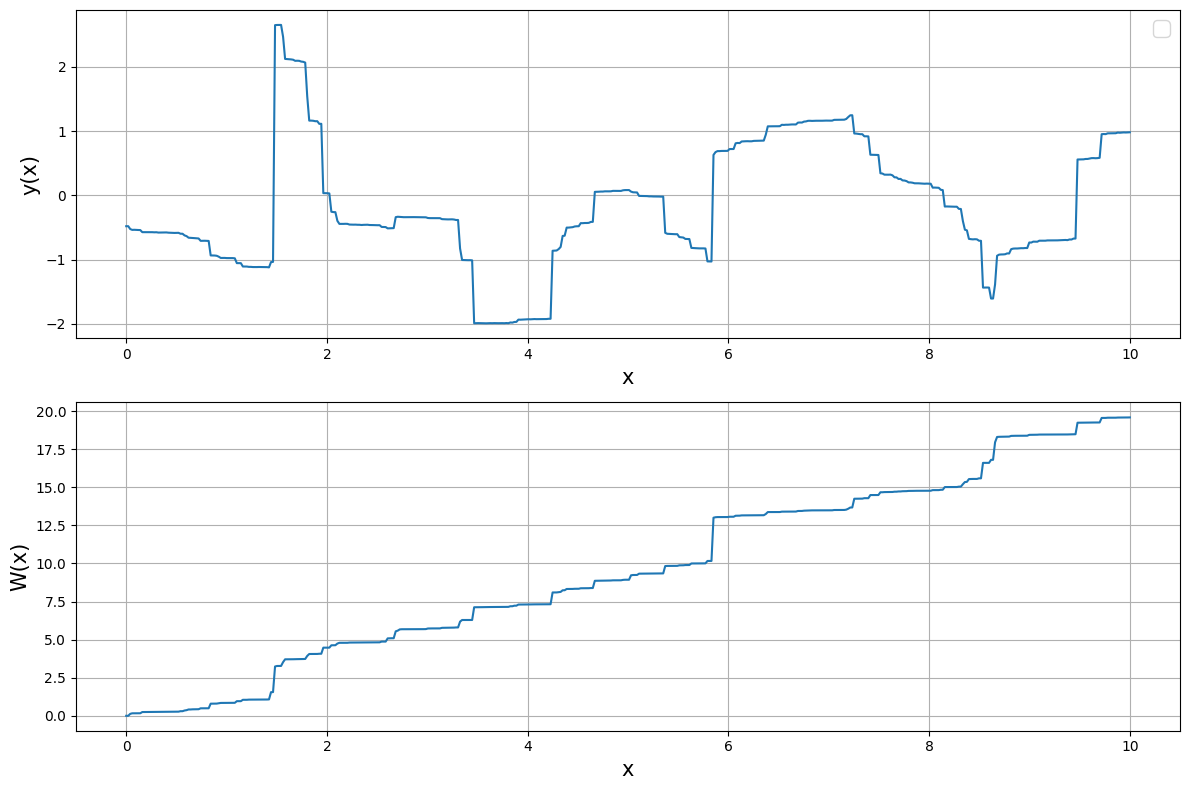

In [220]:
# Set Parameters
t1 = 0.0
t2 = 10.0

num_obs = 500 # (N) number of points e.g. size of data set
num_epochs = 2000
subordinator_truncation = 0.0
kappa = 0.4
delta = 2.3
gamma = 0.65
nProcesses = 1
l = 1

initial_sub = TemperedStableSubordinator(t1, t2, num_obs, num_epochs, subordinator_truncation, kappa=kappa, delta=delta, gamma=gamma).generate_path().reshape(-1,1)
X = initial_sub
Y = GaussianProcess(initial_sub, 1, num_obs).reshape(-1,1)

Xs = np.linspace(0.0, 10.0, num_obs).reshape(-1, 1)

fig, ax = plt.subplots(nrows=2, figsize=(12,8))

ax[0].plot(Xs, Y)
ax[0].set_xlabel('x', fontsize=15)
ax[0].set_ylabel('y(x)', fontsize=15)
ax[0].grid(True)
ax[0].legend(fontsize=15)

ax[1].plot(Xs, initial_sub)
ax[1].set_xlabel('x', fontsize=15)
ax[1].set_ylabel('W(x)', fontsize=15)
ax[1].grid(True)

plt.tight_layout()
plt.show()

In [221]:
def log_likelihood(X, Y):
    kernel = GPy.kern.RBF(input_dim=1)
    sub_kernel = GPy.kern.Brownian(input_dim=1)
    model = GPy.models.GPRegression(X, Y, kernel*sub_kernel)
    log_likelihood = model.log_likelihood()
    return log_likelihood

burn_in = 0

### Data Storage

In [222]:
data = dict()

data['accept_sub_samples'] = []
data['likelihood_samples'] = []
data['accept_likelihood_samples'] = []
data['alphas'] = []
data['accept_alphas'] = []


### Base Case

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48
Iteration: 49
Iteration: 50
Iteration: 51
Iteration: 52
Iteration: 53
Iteration: 54
Iteration: 55
Iteration: 56
Iteration: 57
Iteration: 58
Iteration: 59
Iteration: 60
Iteration: 61
Iteration: 62
Iteration: 63
Iteration: 64
Iteration: 65
Iteration: 66
Iteration: 67
Iteration: 68
Iteration: 69
Iteration: 70
Iteration: 71
Iteration: 72
I

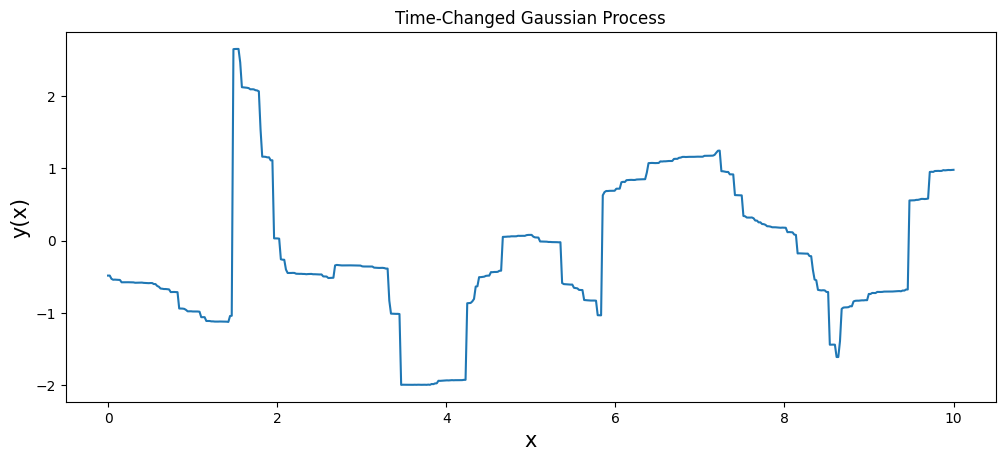

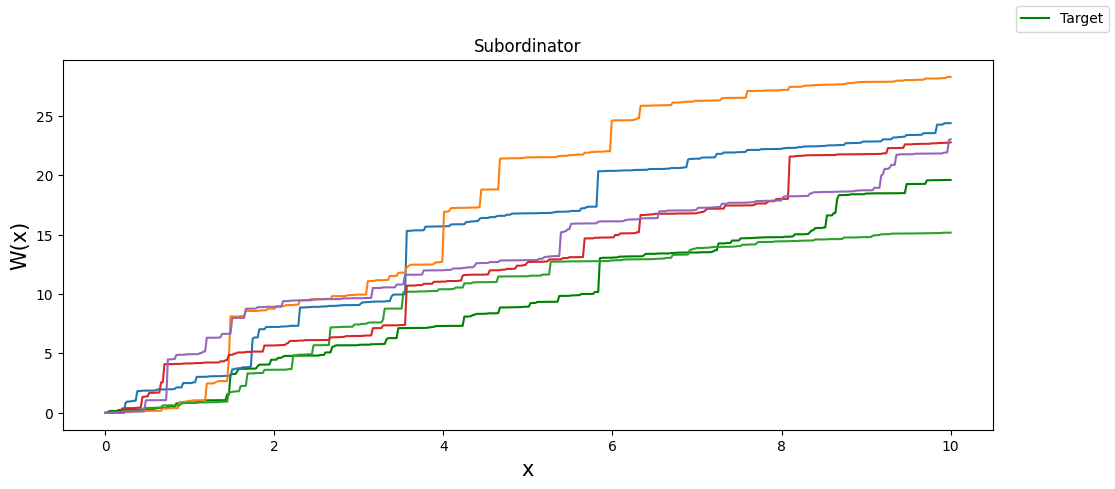

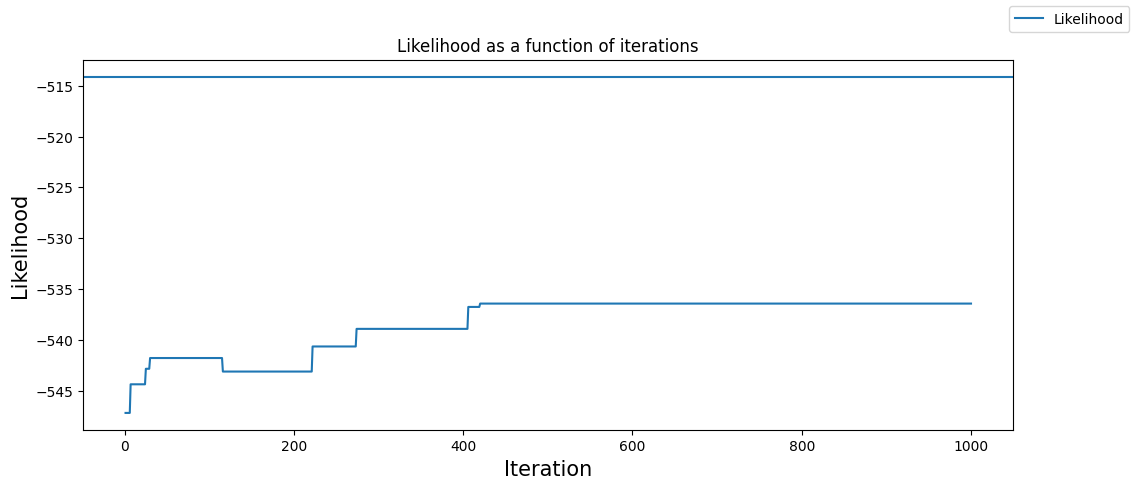

In [223]:
# Run the Metropolis-Hastings algorithm
num_iter = 1000

t1 = 0.0
t2 = 10.0

N = 1

current_sub = TemperedStableSubordinator(t1, t2, int(num_obs/N), num_epochs, subordinator_truncation, kappa=kappa, delta=delta, gamma=gamma).generate_path().reshape(-1,1)
acceptances = 0

accept_sub_samples = []

likelihood_samples = []
accept_likelihood_samples = []

alphas = []
accept_alphas = []


for i in range(num_iter):
    # Draw a new proposal from the proposal distribution
    print('Iteration:', i+1)

    new_sub = TemperedStableSubordinator(t1, t2, int(num_obs/N), num_epochs, subordinator_truncation, kappa=kappa, delta=delta, gamma=gamma).generate_path().reshape(-1,1)
    log_alpha = log_likelihood(new_sub, Y) - log_likelihood(current_sub, Y)
    alpha = np.exp(log_alpha)

    accept = np.random.uniform() < alpha
    alphas.append(alpha)


    if accept:
        current_sub = new_sub
        acceptances += 1
        accept_likelihood_samples.append(log_likelihood(current_sub, Y))
        accept_alphas.append(alpha)
        accept_sub_samples.append(current_sub)

    likelihood_samples.append(log_likelihood(current_sub, Y))        

# Print the acceptance rate
#print('Acceptance rate:', acceptances*100 / num_iter, '%')
print('Number of accepted likelihood samples:', acceptances)
print('Accepted Likelihood samples:', accept_likelihood_samples)
print('Accepted Alphas:', accept_alphas)
print(log_likelihood(X, Y))


data['accept_sub_samples'].append(accept_sub_samples)
data['likelihood_samples'].append(likelihood_samples)
data['accept_likelihood_samples'].append(accept_likelihood_samples)
data['alphas'].append(alphas)
data['accept_alphas'].append(accept_alphas)


Xs = np.linspace(0, 10, int(num_obs/N))

plt.figure(1).set_figwidth(12)
plt.xlabel('x', fontsize=15)
plt.ylabel('y(x)', fontsize=15)
plt.title('Time-Changed Gaussian Process')
plt.plot(Xs, Y)

plt.figure(2).set_figwidth(12)
plt.plot(Xs, initial_sub, label='Target', color='green')
for i in range (5):
    plt.plot(Xs, accept_sub_samples[-1*(i+1)])
plt.title('Subordinator')
plt.xlabel('x', fontsize=15)
plt.ylabel('W(x)', fontsize=15)
plt.figure(2).legend()

plt.figure(3).set_figwidth(12)
plt.plot(np.linspace(1, len(likelihood_samples), len(likelihood_samples)), likelihood_samples, label='Likelihood')
plt.axhline(log_likelihood(X, Y))
plt.title('Likelihood as a function of iterations')
plt.xlabel('Iteration', fontsize=15)
plt.ylabel('Likelihood', fontsize=15)
plt.figure(3).legend()


plt.show()


In [106]:
def jump_density_estimate(x_grid, locations, magnitudes):
    def weighted_Gaussian_kernel(x, mu, sigma, weight):
        u = (x - mu) / abs(sigma)
        y = (1 / (np.sqrt(2 * np.pi) * abs(sigma))) * np.exp(-u * u / 2) * weight
        return y
    prob = [weighted_Gaussian_kernel(x_i, locations, 0.01, magnitudes) for x_i in x_grid]
    density = [np.average(pr) for pr in prob]
    return np.array(density)

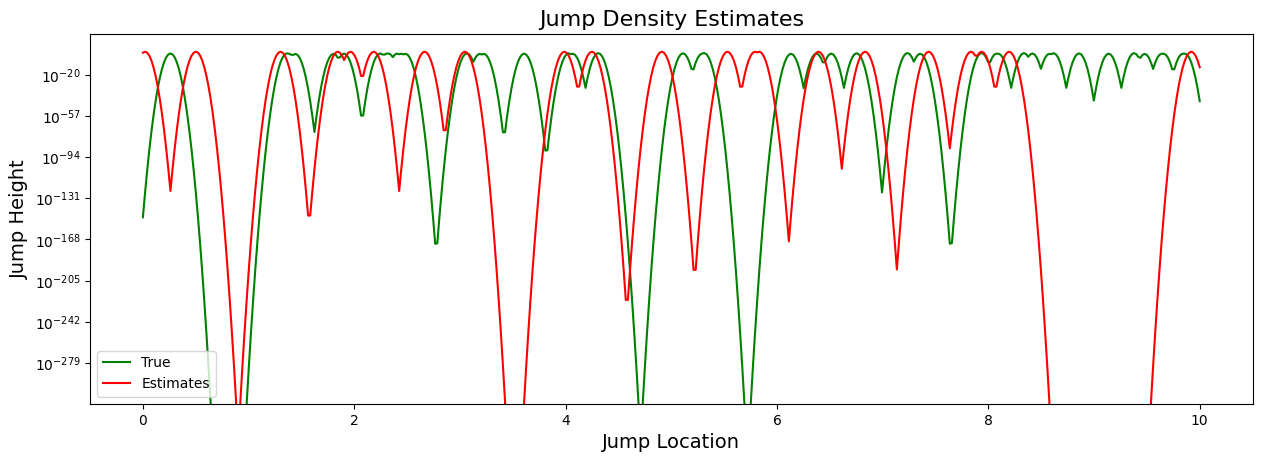

In [108]:
X_jump = []
Y_jump = []
X1_jump = []
Y1_jump = []
X2_jump = []
Y2_jump = []

length = len(initial_sub)

for i in range(length - 1):
    difference = 0.1
    if initial_sub[i + 1] - initial_sub[i] > difference:
        X_jump.append(Xs[i])
        Y_jump.append((initial_sub[i + 1] - initial_sub[i])[0])
    if accept_sub_samples[-1][i + 1] - accept_sub_samples[-1][i] > difference:
        X1_jump.append(Xs[i])
        Y1_jump.append((accept_sub_samples[-1][i + 1] - accept_sub_samples[-1])[0])

plt.figure().set_figwidth(15,10)
plt.yscale('log')
plt.title('Jump Density Estimates', fontsize=16)
plt.ylabel('Jump Height', fontsize=14)
plt.xlabel('Jump Location', fontsize=14)
plt.plot(np.linspace(0, 10, 500), jump_density_estimate(np.linspace(0, 10, 500), X_jump, Y_jump), color='green', label='True')
plt.plot(np.linspace(0, 10, 500), jump_density_estimate(np.linspace(0, 10, 500), X1_jump, Y1_jump), color='red', label='Estimates')
plt.legend(loc='best')

In [224]:
fred = accept_sub_samples[-1]

### `New Version`

In [232]:
accept_sub_samples[-1] = fred

In [233]:
data_accept_sub_samples = []
data_likelihood_samples = []
data_accept_likelihood_samples = []
data_alphas = []
data_accept_alphas = []

In [234]:
# Run the Metropolis-Hastings algorithm
N = 8
steps = 10.0/N
obsv_increment = int(num_obs/N)

t1 = 0.0
t2 = 10.0

acceptances = 0
accept_likelihood_samples = []
accept_alphas = []
current_sub = accept_sub_samples[-1]

for i in range(1000):#500

    print('Iteration:', i+1)

    accept_sub_samples_test = []
    likelihood_samples = []
    alphas = []

    flag = False

    for n in range(N): #5
        new_sub = TemperedStableSubordinator(t1, t2, num_obs, num_epochs, subordinator_truncation, kappa=kappa, delta=delta, gamma=gamma).generate_path().reshape(-1,1)
        new_sub = new_sub[obsv_increment*n:obsv_increment*(n+1)]
        
        if n == 0:
            diff_1 = 0
        else:
            diff_1 = accept_sub_samples[-1][(n)*obsv_increment] - new_sub[0]
        
        if n == N-1:
            diff_2 = 0
        else:
            diff_2 = new_sub[-1] - accept_sub_samples[-1][(n+1)*obsv_increment]
        
        curr_part = new_sub + diff_1 
        next_part = accept_sub_samples[-1][(n+1)*obsv_increment:] + diff_2 + diff_1
        prev_part = accept_sub_samples[-1][:n*obsv_increment]
        
        new_sub = np.concatenate((prev_part, curr_part, next_part))

        log_alpha = log_likelihood(new_sub, Y) - log_likelihood(current_sub, Y)
        alpha = np.exp(log_alpha)

        accept = np.random.uniform() < alpha
        alphas.append(alpha)
        
        if accept:
            current_sub = new_sub
            accept_sub_samples_test.append(current_sub)
            
            flag = True
        
        likelihood_samples.append(log_likelihood(current_sub, Y))
            
    if flag:
        acceptances += 1
        accept_likelihood_samples.append(log_likelihood(current_sub, Y))
        accept_alphas.append(alpha)
        accept_sub_samples = accept_sub_samples_test
        
        data_accept_sub_samples.extend(accept_sub_samples)
        data_accept_likelihood_samples.extend(accept_likelihood_samples)
        data_accept_alphas.extend(accept_alphas)
        
    data_likelihood_samples.extend(likelihood_samples)
    data_alphas.extend(alphas)

Iteration: 1
Iteration: 2
Iteration: 3
Iteration: 4
Iteration: 5
Iteration: 6
Iteration: 7
Iteration: 8
Iteration: 9
Iteration: 10
Iteration: 11
Iteration: 12
Iteration: 13
Iteration: 14
Iteration: 15
Iteration: 16
Iteration: 17
Iteration: 18
Iteration: 19
Iteration: 20
Iteration: 21
Iteration: 22
Iteration: 23
Iteration: 24
Iteration: 25
Iteration: 26
Iteration: 27
Iteration: 28
Iteration: 29
Iteration: 30
Iteration: 31
Iteration: 32
Iteration: 33
Iteration: 34
Iteration: 35
Iteration: 36
Iteration: 37
Iteration: 38
Iteration: 39
Iteration: 40
Iteration: 41
Iteration: 42
Iteration: 43
Iteration: 44
Iteration: 45
Iteration: 46
Iteration: 47
Iteration: 48
Iteration: 49
Iteration: 50
Iteration: 51
Iteration: 52
Iteration: 53
Iteration: 54
Iteration: 55
Iteration: 56
Iteration: 57
Iteration: 58
Iteration: 59
Iteration: 60
Iteration: 61
Iteration: 62
Iteration: 63
Iteration: 64
Iteration: 65
Iteration: 66
Iteration: 67
Iteration: 68
Iteration: 69
Iteration: 70
Iteration: 71
Iteration: 72
I

In [235]:
     print(acceptances)

736


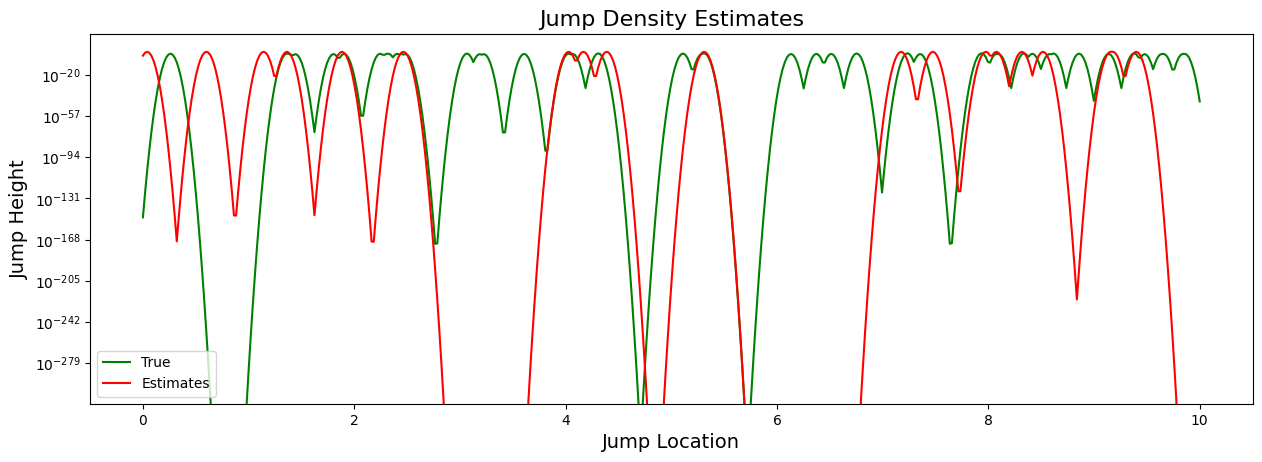

In [145]:
X_jump = []
Y_jump = []
X1_jump = []
Y1_jump = []
X2_jump = []
Y2_jump = []

length = len(initial_sub)

for i in range(length - 1):
    difference = 0.1
    if initial_sub[i + 1] - initial_sub[i] > difference:
        X_jump.append(Xs[i])
        Y_jump.append((initial_sub[i + 1] - initial_sub[i])[0])
    if data_accept_sub_samples[-1][i + 1] - data_accept_sub_samples[-1][i] > difference:
        X1_jump.append(Xs[i])
        Y1_jump.append((data_accept_sub_samples[-1][i + 1] - data_accept_sub_samples[-1])[0])

plt.figure().set_figwidth(15,10)
plt.yscale('log')
plt.title('Jump Density Estimates', fontsize=16)
plt.ylabel('Jump Height', fontsize=14)
plt.xlabel('Jump Location', fontsize=14)
plt.plot(np.linspace(0, 10, 500), jump_density_estimate(np.linspace(0, 10, 500), X_jump, Y_jump), color='green', label='True')
plt.plot(np.linspace(0, 10, 500), jump_density_estimate(np.linspace(0, 10, 500), X1_jump, Y1_jump), color='red', label='Estimates')
plt.legend(loc='best')